In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *

import matplotlib as mpl
import seaborn as sns

In [2]:
# smart diauxers with D=100
N_community = 10000
logD = log(100)
gC = 1.5
# use new parameter rho
rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]

data = []
for R in range(2, 7):
    N = R
    rho_mean = rho_list[R-2]
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R) # enzyme properties, not real growth rates
        rhos = rho_mean * np.ones(N)
        rho_expand = np.tile(rhos, (R, 1))
        g_real = 1/(1/(g_enz*(rho_expand+(1-rho_expand)*R))+1/gC)
        # generate the pref list for smart bugs
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = smart_preference_list(g_real)
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["rho"] = g_enz, pref_list, rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "communities":communities})
filename = "../data/smart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
pickle.dump(data, open(filename, "wb"))

data = []
# semismart diauxers with D=100
for R in range(2, 7):
    N = R
    rho_mean = rho_list[R-2]
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R) # enzyme properties, not real growth rates
        rhos = rho_mean * np.ones(N)
        rho_expand = np.tile(rhos, (R, 1))
        g_real = 1/(1/(g_enz*(rho_expand+(1-rho_expand)*R))+1/gC)
        # generate the pref list for semi smart bugs
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        col = np.argmax(g_real, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["rho"] = g_enz, pref_list, rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "communities":communities})
filename = "../data/semismart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
pickle.dump(data, open(filename, "wb"))

# random diauxers with D=100
data = []
for R in range(2, 7):
    N = R
    rho_mean = rho_list[R-2]
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R) # enzyme properties, not real growth rates
        rhos = rho_mean * np.ones(N)
        # generate the pref list for random bugs
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=N))
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"], community["rho"] = g_enz, pref_list, rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "communities":communities})
filename = "../data/random_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
pickle.dump(data, open(filename, "wb"))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [09:01<00:00, 18.48it/s]


In [4]:
N_community = 10000
data = {}
data["smart_diaux_hwa"] = [[], []]
filename = "../data/smart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    logD, gC = item["logD"], item["gC"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g_enz, pref_list, rhos = item["g"], item["pref_list"], item["rho"]
                G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
                F = F_mat_diaux_hwa(g_enz, gC, pref_list, G, dep_order, logD, rhos)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g_enz, gC, dep_order, G, t, F, env, rhos))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["smart_diaux_hwa"][0].append([feasibility, success_rate])
    data["smart_diaux_hwa"][1].append([stability, err])
print(data["smart_diaux_hwa"])

data["semismart_diaux_hwa"] = [[], []]
filename = "../data/semismart_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    logD, gC = item["logD"], item["gC"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g_enz, pref_list, rhos = item["g"], item["pref_list"], item["rho"]
                G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
                F = F_mat_diaux_hwa(g_enz, gC, pref_list, G, dep_order, logD, rhos)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g_enz, gC, dep_order, G, t, F, env, rhos))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["semismart_diaux_hwa"][0].append([feasibility, success_rate])
    data["semismart_diaux_hwa"][1].append([stability, err])
print(data["semismart_diaux_hwa"])

data["random_diaux_hwa"] = [[], []]
filename = "../data/random_diaux_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    logD, gC = item["logD"], item["gC"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"][:1]:
                g_enz, pref_list, rhos = item["g"], item["pref_list"], item["rho"]
                G = G_mat_diaux_hwa(g_enz, gC, pref_list, dep_order, rhos)
                F = F_mat_diaux_hwa(g_enz, gC, pref_list, G, dep_order, logD, rhos)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_diaux_hwa(g_enz, gC, dep_order, G, t, F, env, rhos))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["random_diaux_hwa"][0].append([feasibility, success_rate])
    data["random_diaux_hwa"][1].append([stability, err])
print(data["random_diaux_hwa"])

[[[0.5006, 0.5006], [0.2463, 0.239], [0.1195, 0.1105], [0.0613, 0.0535], [0.0324, 0.0263]], [[-1.2445596020261596, 0.012555013176970536], [-1.2025029726329963, 0.012422701238239929], [-1.1956283999227548, 0.014482715832334183], [-1.1643052174770805, 0.016852684204977805], [-1.1445058262460224, 0.021130481925549]]]
[[[0.4997, 0.4997], [0.3136, 0.2749], [0.216, 0.1595], [0.1606, 0.0996], [0.1209, 0.0606]], [[-1.2313694878704438, 0.012455609639722948], [-1.178019496040696, 0.011544436193041721], [-1.1511849724044176, 0.012485023080663824], [-1.157711583018281, 0.013294532290621788], [-1.143600115754123, 0.015917109164344603]]]
[[[0.5402, 0.3942], [0.3073, 0.1241], [0.1808, 0.0368], [0.1031, 0.0108], [0.066, 0.0021]], [[-1.5601715325861125, 0.01329206676153979], [-1.4423717984565156, 0.01595615959489728], [-1.383536888059585, 0.02380388972921048], [-1.361031203983752, 0.038835718034379595], [-1.2106846814925991, 0.0662713449078009]]]


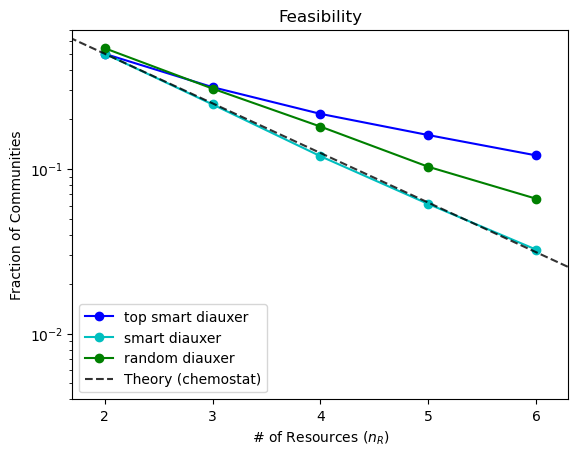

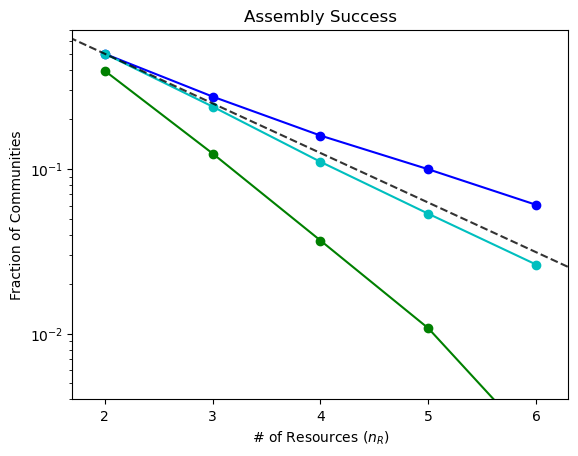

In [5]:
plt.plot(range(2, 7), [i[0] for i in data["semismart_diaux_hwa"][0]], marker="o", color="b", alpha=1, label="top smart diauxer")
plt.plot(range(2, 7), [i[0] for i in data["smart_diaux_hwa"][0]], marker="o", color="c", alpha=1, label="smart diauxer")
plt.plot(range(2, 7), [i[0] for i in data["random_diaux_hwa"][0]], marker="o", color="g", alpha=1, label="random diauxer")
plt.yscale("log")
plt.xlabel("# of Resources ($n_R$)")
plt.ylabel("Fraction of Communities")
plt.xlim(1.7, 6.3)
plt.ylim(0.004, 0.7)
xspace = np.linspace(1, 7, 300)
yspace = 1/2**(xspace-1)
plt.plot(xspace, yspace, color='k', linestyle="--", alpha=0.8, label = "Theory (chemostat)")
plt.legend()
plt.title("Feasibility")
# plt.savefig("../figures/feasibility_plot.pdf")
plt.show()

plt.plot(range(2, 7), [i[1] for i in data["semismart_diaux_hwa"][0]], marker="o", color="b", alpha=1, label="top smart diauxer")
plt.plot(range(2, 7), [i[1] for i in data["smart_diaux_hwa"][0]], marker="o", color="c", alpha=1, label="smart diauxer")
plt.plot(range(2, 7), [i[1] for i in data["random_diaux_hwa"][0]], marker="o", color="g", alpha=1, label="random diauxer")
plt.yscale("log")
plt.xlabel("# of Resources ($n_R$)")
plt.ylabel("Fraction of Communities")
plt.xlim(1.7, 6.3)
plt.ylim(0.004, 0.7)
xspace = np.linspace(1, 7, 300)
yspace = 1/2**(xspace-1)
plt.plot(xspace, yspace, color='k', linestyle="--", alpha=0.8, label = "Theory (chemostat)")
plt.title("Assembly Success")
# plt.legend()
# plt.savefig("../figures/assembly_success_plot.pdf")
plt.show()

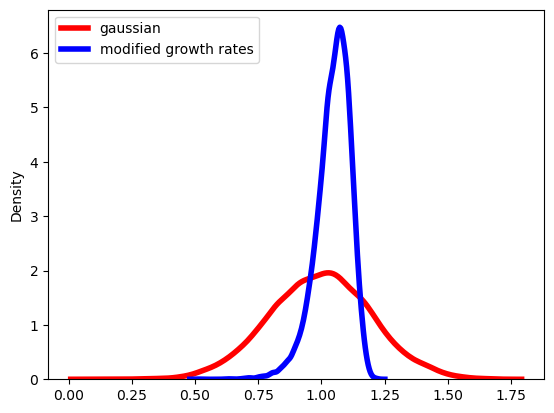

In [ ]:
# difference in distribution
gC = 1.5
rho = 0.0404
R = 4
g_gauss_list = list(generate_g(100, 100).flatten())
g_tilted_list = list(g_convert(generate_g(100, 100)/(rho*R+1-rho)*R, gC).flatten())
fig, ax1 = plt.subplots()
sns.kdeplot(g_gauss_list,  color='r', linewidth=4, label="gaussian")
sns.kdeplot(g_tilted_list,  color='b', linewidth=4, label="modified growth rates")
plt.legend()